0


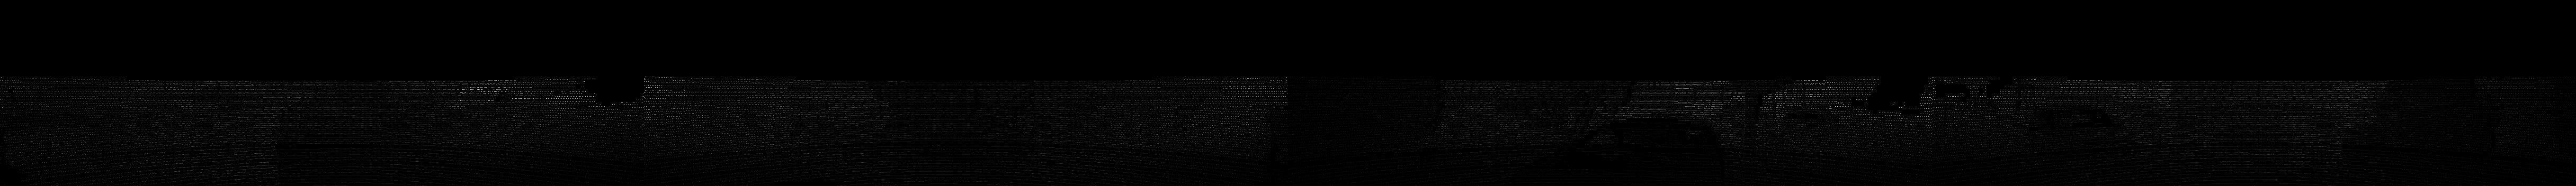

In [1]:
from dataloaders.pc_dataset import SemanticKITTI
import argparse
import yaml
from easydict import EasyDict
from PIL import Image
from torchvision.transforms import transforms
import numpy as np
from torch.utils.data import DataLoader

totensor = transforms.ToTensor()
topil = transforms.ToPILImage()

args = argparse.ArgumentParser()
args = args.parse_args(args=[])
with open('./config/semantic.yaml') as stream:
    config = yaml.safe_load(stream)
config.update(vars(args))
args = EasyDict(config)
dataset = SemanticKITTI(args=args)
dataloader = DataLoader(dataset, 1, False)
cur_data = next(iter(dataloader))

# img = np.squeeze(cur_data['velodyne_proj_img0'][0].data.cpu().numpy())
# img = (img * 256.0).astype('uint16')
# img_buffer = img.tobytes()
# imgsave = Image.new("I", img.T.shape)
# imgsave.frombytes(img_buffer, 'raw', "I;16")
# imgsave.save('./saveimg.png')
# imgsave.show()

# cur_data['velodyne_proj_img0'][cur_data['denser_coordinate'][:,1], cur_data['denser_coordinate'][:,0]] = 500.
show_img = topil(cur_data['velodyne_proj_img'][0]/cur_data['velodyne_proj_img'][0].max())
show_img.show()

In [2]:
cur_iter = iter(dataloader)

0


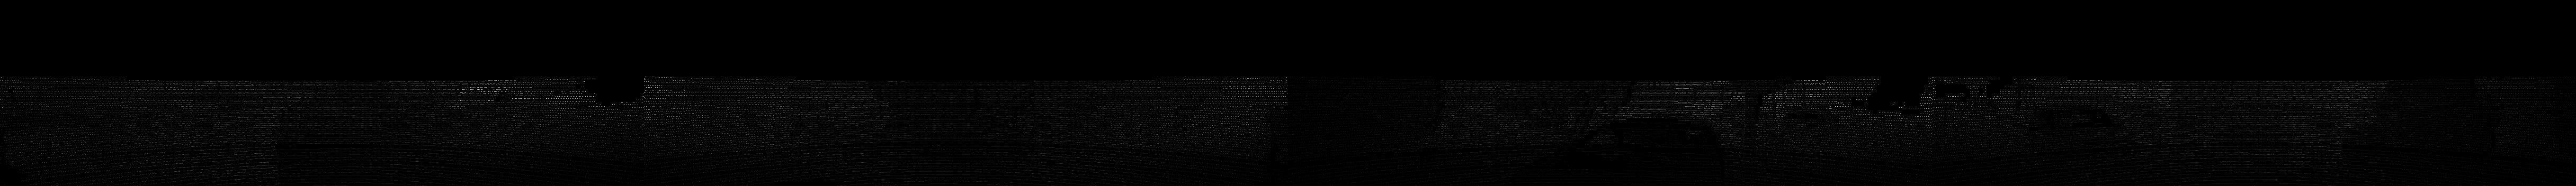

In [3]:
cur_data = next(cur_iter)
show_img = topil(cur_data['velodyne_proj_img'][0]/cur_data['velodyne_proj_img'][0].max())
show_img.show()

torch.Size([1, 1, 176, 608])


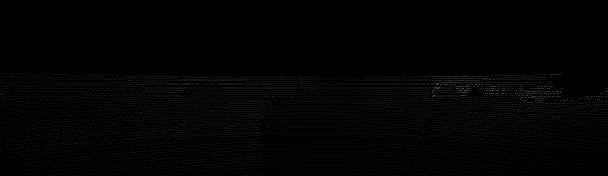

In [4]:
import torch.nn.functional as F
import torch

img_torch = cur_data['velodyne_proj_img0']
H = img_torch.shape[2]
W = img_torch.shape[3]
img_unfold = F.unfold(img_torch, 2, stride=2)
_, index = img_unfold.topk(1, dim=1)
img_fold = torch.gather(img_unfold, dim=1, index=index).view(1, 1, H // 2, W // 2)
print(img_fold.shape)
show_pooling = topil(img_fold[0]/255.)
show_pooling.show()

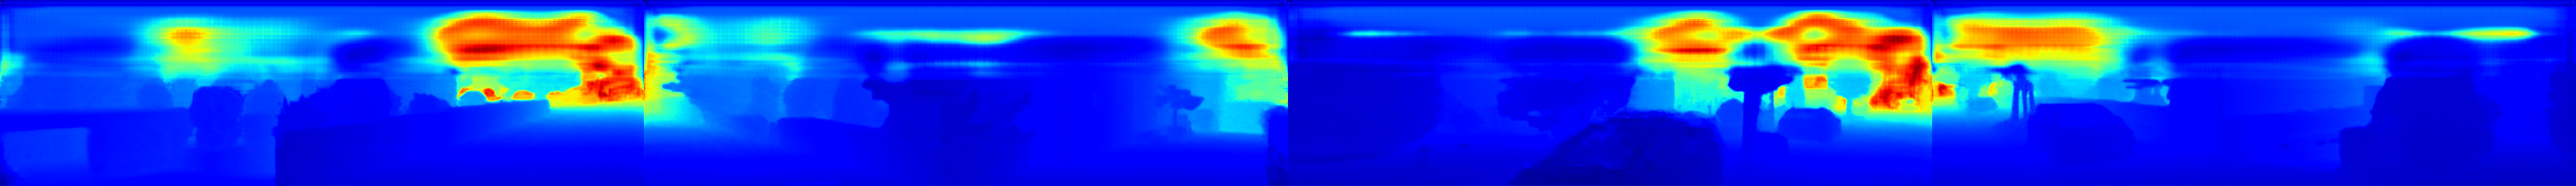

In [5]:
from sparse2dense._2dpapenet import get_model as DepthCompletionModel
from matplotlib import cm

model = DepthCompletionModel(args).cuda()
model = model.load_from_checkpoint('/root/autodl-nas/best_2dpapenet_conv.ckpt', args=args, strict=False).cuda()
with torch.no_grad():
    output_data = model(cur_data)
refine_img = output_data['all_refined_depth']

cmap = cm.get_cmap('jet')
sm = cm.ScalarMappable(cmap=cmap)
color_range = sm.to_rgba(np.linspace(0,1,256), bytes=True)[:, 0:3]

refine_img0 = output_data['all_refined_depth'].data.cpu().numpy()
img = np.squeeze(refine_img0/refine_img0.max()*255.).astype(np.uint8)
img = color_range[img].astype(np.uint8)
imgsave = Image.fromarray(img)
imgsave.show()

torch.Size([1, 428032])
torch.Size([159552, 4])


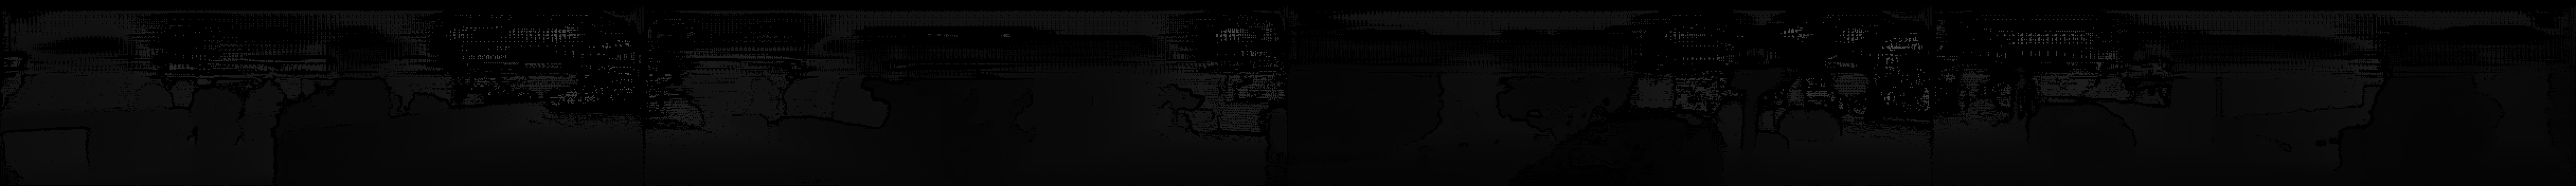

In [6]:
unfold_op = torch.nn.Unfold(2, stride=2)
fold_op = torch.nn.Fold((refine_img.shape[-2], refine_img.shape[-1]), 2, stride=2)
refine_edge = unfold_op(refine_img).permute(0, 2, 1).contiguous()
top_num, _ = refine_edge.topk(1, dim=2, largest=True)
bottom_num, _ = refine_edge.topk(1, dim=2, largest=False)
mask = (top_num - bottom_num > 0.5).squeeze(-1)
refine_edge[mask] = 0
refine_img = fold_op(refine_edge.permute(0,2,1).contiguous())
# output_data['all_refined_depth'] = refine_img
print(mask.shape)
print(refine_edge[mask].shape)

img = np.squeeze(refine_img.data.cpu().numpy())
img = (img).astype('uint16')
img_buffer = img.tobytes()
imgsave = Image.new("I", img.T.shape)
imgsave.frombytes(img_buffer, 'raw', "I;16")
imgsave.show()

In [7]:
print(output_data.keys())

dict_keys(['raw_data', 'K', 'T_velo2img', 'T_4img', 'T_xyz', 'T_rot', 'position', 'proj_points', 'sparse_proj_points', 'proj_distance', 'distance', 'denser_coordinate', 'denser_coordinate_lines', 'velodyne_proj_img', 'velodyne_proj_img0', 'velodyne_proj_img1', 'velodyne_proj_img2', 'velodyne_proj_img3', 'd', 'geo_s1', 'geo_s2', 'geo_s3', 'geo_s4', 'geo_s5', 'geo_s6', 'mid_branch_output', 'mid_branch_confidence', 'mid_branch_feature', 'dd_feature', 'dd_branch_output', 'dd_branch_confidence', 'fuse_output', 'all_fuse_output', 'refined_depth', 'all_refined_depth'])


(352, 4864)
(352, 4864)
torch.Size([16352, 2])


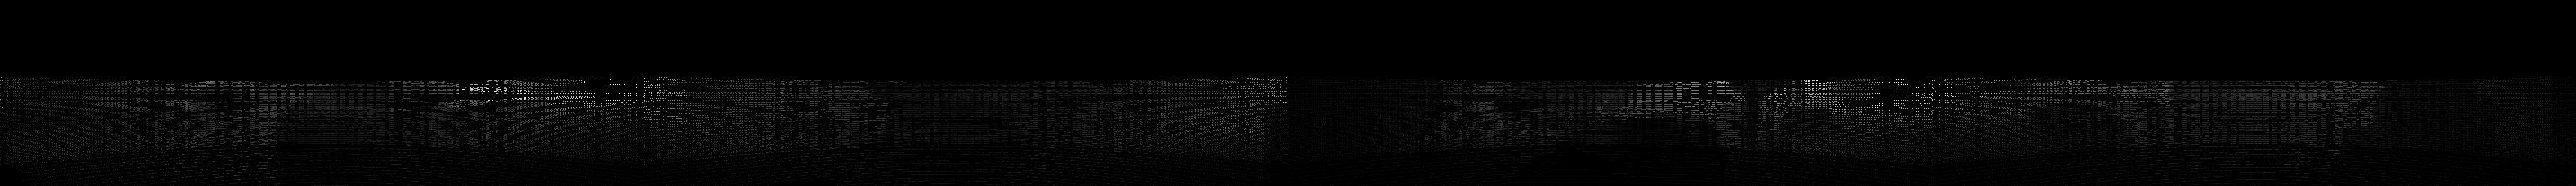

In [8]:
sparse_img = cur_data['velodyne_proj_img'][0].permute(1, 2, 0).cpu().numpy().squeeze()
max_dist = sparse_img.max()
print(sparse_img.shape)
dense_img = cur_data['all_refined_depth'][0].permute(1, 2, 0).cpu().detach().numpy().squeeze()
print(dense_img.shape)
dense_coord = output_data['denser_coordinate'][0]
print(dense_coord.shape)
sparse_img[dense_coord[:, 1], dense_coord[:, 0]] = dense_img[dense_coord[:, 1], dense_coord[:, 0]]
sparse_img[dense_coord[:, 1], dense_coord[:, 0] + W] = dense_img[dense_coord[:, 1], dense_coord[:, 0] + W]
sparse_img[dense_coord[:, 1], dense_coord[:, 0] + 2 * W] = dense_img[dense_coord[:, 1], dense_coord[:, 0] + 2 * W]
sparse_img[dense_coord[:, 1], dense_coord[:, 0] + 3 * W] = dense_img[dense_coord[:, 1], dense_coord[:, 0] + 3 * W]

sparse_img[sparse_img > max_dist] = 0
sparse_img = (sparse_img - sparse_img.min()) / (sparse_img.max() - sparse_img.min()) * 255.
denser_img = Image.fromarray(sparse_img)
denser_img.show()

In [9]:
denser_coordinate_lines = [lines.cpu().numpy().squeeze() for lines in output_data['denser_coordinate_lines']]
sparse_proj_points = [points.cpu().numpy().squeeze() for points in output_data['sparse_proj_points']]
K = output_data['K'][0].cpu().numpy().squeeze()
T_velo2img = output_data['T_velo2img'].cpu().numpy().squeeze()[:3, :3]
T_4img = output_data['T_4img'].cpu().numpy().squeeze()[:3, :3]
T_rot = output_data['T_rot'].cpu().numpy().squeeze()[:3, :3]

K_inv = K[:3, :3]
K_inv = np.linalg.inv(K_inv)
T_velo2img_inv = np.linalg.inv(T_velo2img)
T_4img_inv = np.linalg.inv(T_4img)
# T_rot_inv = np.identity(3)
T_rot_inv = np.linalg.inv(T_rot)

print(len(denser_coordinate_lines))
for i in range(len(denser_coordinate_lines)):
    insert_coords = denser_coordinate_lines[i]
    cat_ones = np.ones((insert_coords.shape[0], 1))
    insert_proj_points = np.concatenate([insert_coords, cat_ones], axis=1)
    # -pi/4  pi/4
    z_axis = dense_img[insert_coords[:, 1], insert_coords[:, 0]]
    z_axis = np.expand_dims(z_axis, -1)
    insert_proj_points0 = (K_inv @ insert_proj_points.T).T * z_axis
    mask = insert_proj_points0[:, 2] > 0
    insert_proj_points0 = insert_proj_points0[mask]
    insert_proj_points0 = (T_rot_inv @ T_velo2img_inv @ insert_proj_points0.T).T

    # pi/4  3pi/4
    z_axis = dense_img[insert_coords[:, 1], insert_coords[:, 0] + W]
    z_axis = np.expand_dims(z_axis, -1)
    insert_proj_points1 = (K_inv @ insert_proj_points.T).T * z_axis
    mask = insert_proj_points1[:, 2] > 0
    insert_proj_points1 = insert_proj_points1[mask]
    insert_proj_points1 = (T_rot_inv @ T_4img_inv @ T_velo2img_inv @ insert_proj_points1.T).T
    # 3pi/4  -3pi/4
    z_axis = dense_img[insert_coords[:, 1], insert_coords[:, 0] + 2 * W]
    z_axis = np.expand_dims(z_axis, -1)
    insert_proj_points2 = (K_inv @ insert_proj_points.T).T * z_axis
    mask = insert_proj_points2[:, 2] > 0
    insert_proj_points2 = insert_proj_points2[mask]
    insert_proj_points2 = (T_rot_inv @ T_4img_inv @ T_4img_inv @ T_velo2img_inv @ insert_proj_points2.T).T
    # -3pi/4  -pi/4
    z_axis = dense_img[insert_coords[:, 1], insert_coords[:, 0] + 3 * W]
    z_axis = np.expand_dims(z_axis, -1)
    insert_proj_points3 = (K_inv @ insert_proj_points.T).T * z_axis
    mask = insert_proj_points3[:, 2] > 0
    insert_proj_points3 = insert_proj_points3[mask]
    insert_proj_points3 = (T_rot_inv @ T_4img_inv @ T_4img_inv @ T_4img_inv @ T_velo2img_inv @ insert_proj_points3.T).T

    insert_proj_points = [insert_proj_points0, insert_proj_points1, insert_proj_points2, insert_proj_points3]
    insert_proj_points = np.concatenate(insert_proj_points, axis=0)
    # print(insert_proj_points.shape)
    # print(insert_proj_points3.shape)
    # sparse_proj_points.insert(i, insert_proj_points)
    # sparse_proj_points.append(insert_proj_points)
    sparse_proj_points.insert(2 * i + 1, insert_proj_points)
    # print(insert_proj_points.shape)

sparse_proj_points = np.concatenate(sparse_proj_points, axis=0)
print(len(sparse_proj_points))
print(output_data['proj_points'].size)

32
190337
<built-in method size of Tensor object at 0x7fb1a4869680>


In [10]:
cat_ones = np.ones((sparse_proj_points.shape[0], 1))
sparse_proj_points = np.concatenate([sparse_proj_points, cat_ones], axis=1).astype(np.float32)
T_xyz = output_data['T_xyz']
T_xyz_inv = np.linalg.inv(T_xyz)
sparse_proj_points = (T_xyz_inv @ sparse_proj_points.T).T.astype(np.float32)
sparse_proj_points.tofile('./bin/denserpc.bin')
print(K)

[[608.   0. 608.   0.]
 [  0. 608. 176.   0.]
 [  0.   0.   1.   0.]]


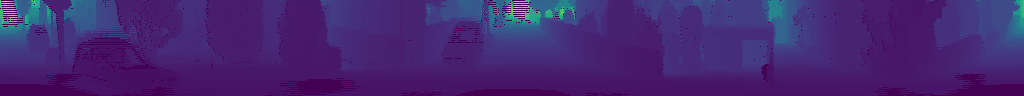

In [11]:
from projection.laserscan import LaserScan
import argparse
from torchvision.transforms import transforms
import numpy as np
import matplotlib
from matplotlib import cm
import yaml
args = argparse.ArgumentParser("test")
args.add_argument("--config", type=str, default= "./config/semantic-kitti.yaml")
args = args.parse_args(args=[])

with open(args.config) as config:
    CFG = yaml.safe_load(config)
color_dict = CFG['color_map']
topil = transforms.ToPILImage()

laserscan = LaserScan(project=True, H=64+32)
scan_path = "./bin/denserpc.bin"
# scan_path = "/media/shitong/passport/SemanticKITTI/sequences/03/velodyne/000001.bin"
laserscan.open_scan(scan_path, scan_unfold=True)

# cmap = matplotlib.colormaps.get_cmap('viridis')
cmap = cm.get_cmap('viridis')
sm = cm.ScalarMappable(cmap=cmap)
color_range = sm.to_rgba(np.linspace(0,1,256), bytes=True)[:, 0:3]

range_img = laserscan.proj_range
range_img = ((range_img-range_img.min())/(range_img.max()-range_img.min())*255).astype(np.uint8)
range_img_color = color_range[range_img].astype(np.uint8)

range_img = topil(range_img_color)
range_img.show()
